In [ ]:
#Basic libraries
import os
import numpy as np
import copy
import random
import matplotlib.pyplot as plt


#Framework
import torch
import torchvision

#data and its management related libraries
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from PIL import Image #python imaging library
import cv2


#for creating neural networks
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

#for optimising neural networks
import torch.optim as optim

#for metrics and analysis
import sklearn
from torchsummary import summary



In [ ]:
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print("Device in Use:",device)

Using PyTorch version: 2.1.0+cu121 CUDA: False
Device in Use: cpu


In [ ]:
torch.manual_seed(42) # Setting the seed

#Tensors
Tensors are the PyTorch equivalent to Numpy arrays, with the addition to also have support for GPU acceleration. The name "tensor" is a generalization of concepts. For instance, a vector is a 1-D tensor, and a matrix a 2-D tensor. When working with neural networks, tensors of various shapes and number of dimensions are used.

Most common functions from numpy can be used on tensors as well. Actually, since numpy arrays are so similar to tensors, tensors could be converted to numpy arrays (and back).

**Initialization**
There are many possible options, the simplest one is to call torch.Tensor passing the desired shape as input argument. The function torch.Tensor allocates memory for the desired tensor, but reuses any values that have already been in the memory. To directly assign values to the tensor during initialization, there are many alternatives including:

1.   torch.zeros: Creates a tensor filled with zeros
2.   torch.ones: Creates a tensor filled with ones
3.   torch.rand: Creates a tensor with random values uniformly sampled between 0 and 1
4.   torch.randn: Creates a tensor with random values sampled from a normal distribution with mean 0 and variance 1
5.   torch.arange: Creates a tensor containing the values  N,N+1,N+2,...,M
6.   torch.Tensor (input list): Creates a tensor from the list elements you provide




In [ ]:
x = torch.Tensor(2, 3, 4)
print(x)

tensor([[[ 2.3705e-26,  4.3217e-41,  2.4459e-26,  4.3217e-41],
         [ 1.9973e-23,  4.3216e-41,  7.5449e-27,  4.3217e-41],
         [ 2.4968e-26,  4.3217e-41,  2.1885e-26,  4.3217e-41]],

        [[ 5.4831e-24,  4.3216e-41,  2.4971e-26,  4.3217e-41],
         [ 1.0457e-23,  4.3216e-41,  9.1084e-44,  0.0000e+00],
         [-4.9951e+35,  3.0763e-41,  4.0981e-26,  4.3217e-41]]])


#### Tensor to Numpy, and Numpy to Tensor

Tensors can be converted to numpy arrays, and numpy arrays back to tensors. To transform a numpy array into a tensor, we can use the function `torch.from_numpy`:

In [ ]:
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)

print("Numpy array:", np_arr)
print("PyTorch tensor:", tensor)

Numpy array: [[1 2]
 [3 4]]
PyTorch tensor: tensor([[1, 2],
        [3, 4]])


To transform a PyTorch tensor back to a numpy array, we can use the function `.numpy()` on tensors:

In [ ]:
tensor = torch.arange(4)
np_arr = tensor.numpy()

print("PyTorch tensor:", tensor)
print("Numpy array:", np_arr)

PyTorch tensor: tensor([0, 1, 2, 3])
Numpy array: [0 1 2 3]


#Data Loader

In [ ]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
    #transforms.RandomRotation(45),
    #t.Normalize((0.329), (0.265)),
     ])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 138817992.92it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25299852.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43905125.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10292019.86it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



1. **transform** holds code for whatever transformations you will apply to your data.
2. **trainloader** is what holds the data loader object which takes care of shuffling the data and constructing the batches.
3. **batch_size:** Number of samples to stack per batch
shuffle: If True, the data is returned in a random order. This is important during training for introducing stochasticity.
4. **num_workers:** Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
5. **pin_memory:** If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
6. **drop_last:** If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.


In [ ]:
print(trainset)
print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [ ]:
trainset.data.shape,testset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
trainset.targets.shape,testset.targets.shape

(torch.Size([60000]), torch.Size([10000]))

<class 'PIL.Image.Image'>
Label :  tensor(5)


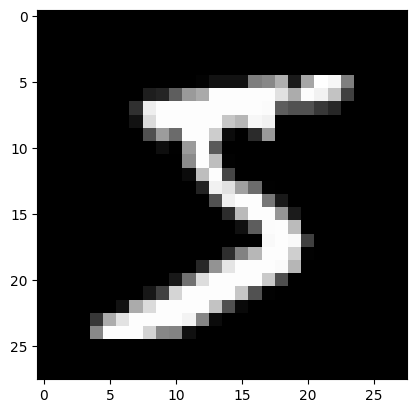

In [ ]:
image = transforms.ToPILImage(mode=None)(trainset.data[0,:,:])
print(type(image))
plt.imshow(image,cmap='gray')
print('Label : ',trainset.targets[0])

#Networks

The package torch.nn defines a series of useful classes like linear networks layers, activation functions, loss functions etc.


Base Class: nn.Module \\
A Sequential container: nn.Sequential \\
A module list: nn.ModuleList \\

Different layers of neural network:
1.   Linear Layers
2.   Activations
3.   Colvolution Layers
4.   Pooling Layers
5.   Dropout Layers
6.   Normalization Layers
7.   Recurrent Layers
8.   Transformer Layers
9.   Vision Layers
10.  Shuffle Layers, etc.

A full list can be found [here](pytorch.org/docs/stable/nn.html). In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already.

Additionally to torch.nn, there is also torch.nn.functional. It contains functions that are used in network layers.

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.d1 = nn.Linear(28 * 28, 128)
        #self.dropout = nn.Dropout(p=0.2)
        self.d2 = nn.Linear(128, 10,bias=False)
        self.relu=nn.ReLU()
        self.seq_container=nn.Sequential(nn.Linear(10, 10,bias=False),
                                         nn.ReLU(),
                                         nn.Linear(10, 10,bias=True))

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.d1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        logits = self.d2(x)
        #logits=self.seq_container(logits)
        out = F.softmax(logits, dim=1)
        return out

In [ ]:
model = Classifier()
print(model)

Classifier(
  (d1): Linear(in_features=784, out_features=128, bias=True)
  (d2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break


batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [ ]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter d1.weight, shape torch.Size([128, 784])
Parameter d1.bias, shape torch.Size([128])
Parameter d2.weight, shape torch.Size([10, 128])
Parameter d2.bias, shape torch.Size([10])


In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


#Optimizers

For updating the parameters, PyTorch provides the package `torch.optim` that has most popular optimizers implemented. We will discuss the specific optimizers and their differences later in the course, but will for now use the simplest of them: `torch.optim.SGD`. Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1.

The optimizer provides two useful functions: `optimizer.step()`, and `optimizer.zero_grad()`. The step function updates the parameters based on the gradients as explained above. The function `optimizer.zero_grad()` sets the gradients of all parameters to zero. While this function seems less relevant at first, it is a crucial pre-step before performing backpropagation. If we call the `backward` function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwriting them. This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them. Hence, remember to call `optimizer.zero_grad()` before calculating the gradients of a batch.

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Loss modules

We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. However, PyTorch already provides a list of predefined loss functions which we can use (see [here](https://pytorch.org/docs/stable/nn.html#loss-functions) for a full list). For instance, for BCE, PyTorch has two modules: `nn.BCELoss()`, `nn.BCEWithLogitsLoss()`. While `nn.BCELoss` expects the inputs $x$ to be in the range $[0,1]$, i.e. the output of a sigmoid, `nn.BCEWithLogitsLoss` combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on "logits" where possible (remember to not apply a sigmoid on the output of the model in this case!). For our model defined above, we therefore use the module `nn.BCEWithLogitsLoss`.

In [ ]:
criterion = nn.CrossEntropyLoss()

#Training and Validating the Model
Now it's time to train the model. The code portion that follows can be descrive in the following steps:

The first thing in training a neural network model is defining the training loop, which is achieved by:
for epoch in range(num_epochs):
    ...
We define two variables, training_running_loss and train_acc that will help us to monitor the running accuracy and loss of the modes while it trains over the different batches.

model.train() explicitly indicates that we are ready to start training.

Notice how we are iterating over the dataloader, which conveniently gives us the batches in image-label pairs.

That second for loop means that for every training step we will iterate over all the batches and train the model over them.

We feed the model the images via model(images) and the output are the predictions of the model.

The predictions together with the target labels are used to compute the loss using the loss function we defined earlier.

Before we update our weights for the next round of training, we perform the following steps:

we use the optimizer object to reset all the gradients for the variables it will update. This is a safe step and it doesn't overwrites the gradients the model accumulates while training (those are stored in a buffer link text via the `loss.backward() call)
loss.backward() simply computes the gradient of the loss w.r.t to the model parameters
optimizer.step() then ensures that the model parameters are updated
Then we gather and accumulate the loss and accuracy, which is what we will use to tell us if the model is learning properly

In [ ]:
num_epochs = 5
model = model.to(device)

In [ ]:
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
## train the model
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## commence training
    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predictions, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 2.3010 | Train Accuracy: 13.40
Epoch: 1 | Loss: 2.2968 | Train Accuracy: 18.31
Epoch: 2 | Loss: 2.2916 | Train Accuracy: 22.37


KeyboardInterrupt: 

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 24.59


In [ ]:
state_dict = model.state_dict()
print(state_dict)
torch.save(state_dict, "model.pt") #.pt/.pth or other extensions

OrderedDict([('d1.weight', tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
        ...,
        [-0.0195,  0.0034,  0.0302,  ..., -0.0030, -0.0317,  0.0128],
        [-0.0107,  0.0221, -0.0158,  ..., -0.0121,  0.0042,  0.0318],
        [-0.0106,  0.0342,  0.0240,  ...,  0.0091,  0.0174,  0.0041]])), ('d1.bias', tensor([-2.7039e-04,  2.6176e-02,  2.6464e-02,  4.8763e-03, -3.2198e-02,
         1.9969e-02,  3.3946e-02, -8.1376e-03, -6.7793e-03, -4.6531e-03,
        -2.7394e-03,  3.5692e-02,  1.4137e-02, -3.0750e-02, -1.5529e-02,
        -1.8795e-03, -1.5544e-02, -2.9410e-02,  1.4686e-02,  3.0404e-02,
         8.0401e-03, -1.7666e-03,  3.4503e-02, -1.3785e-02, -2.1913e-02,
        -5.5803e-03, -2.3942e-02,  2.7177e-04, -3.5056e-02, -3.1385e-02,
        -2.0037e-03,  2.1356e-02,  6.5618e-03, -3.2107e-02,  3.0459e-02,
         2.984

In [ ]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("model.pt")

# Create a new model and load the state
new_model = Classifier()
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same

<All keys matched successfully>

# **Additional Information**

PyTorch Cheat Sheet : https://pytorch.org/tutorials/beginner/ptcheat.html

#Custom Data Loader

A sample custom loader desinged to handle video data, a set of 3 frames is being loaded here.

In [ ]:
#Custom Data Loader
from torch.utils import data

class custom_data_loader(data.Dataset):

  def __init__(self, data, labels,transforms ,aug = True, crop=False,crop_shape = (256,256), resize=True, resize_shape=[256,256]):

        self.data =data
        self.labels=labels

        self.transforms=transforms

        self.aug = aug

        self.crop=crop
        self.crop_shape = crop_shape

        self.resize = resize
        self.resize_shape = resize_shape


  def __len__(self):
        return len(self.x_list)

  def __getitem__(self, index):

      image=np.zeros((3,self.resize_shape[0],self.resize_shape[1],3),np.float32)
      label=np.zeros((3,100))

      image_file_list=self.x_list[index]
      image[0,:,:,:],label[0,:]=self.get_image_labels(image_file_list[0],self.y_list,self.resize,self.resize_shape)
      image[1,:,:,:],label[1,:]=self.get_image_labels(image_file_list[1],self.y_list,self.resize,self.resize_shape)
      image[2,:,:,:],label[2,:]=self.get_image_labels(image_file_list[2],self.y_list,self.resize,self.resize_shape)

     if self.aug:

          transformed=self.transforms(image=image[0],image1=image[1],image2=image[2])
          image[0] = transformed["image"]
          image[1] = transformed["image1"]
          image[2] = transformed["image2"]

      return self.transform_image(image), torch.from_numpy(label)


  def get_image_labels(self, image_name,y_list,resize,resize_shape):

      image_file_name=image_name
      image = None
      # print(image_file_name)
      if os.path.isfile(image_file_name):
          image=cv2.imread(image_file_name)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          img_shape=image.shape

      else:
          print('ERROR: couldn\'t find image -> ', image_file_name)
      if image is None:
          print('ERROR: couldn\'t find image -> ', image_file_name)

      label_ref=image_file_name.split('/')
      label_id=label_ref[-2]+label_ref[-1].split('.')[0]

      label=y_list[label_id]

      if label is None:
          print('ERROR: couldn\'t find label -> ', label_id)

# resize to 512*512 and convert back to np
      if resize:
          rs=(self.resize_shape[0],self.resize_shape[1])
          im=torch.from_numpy(image)
          im=im.permute(2,0,1)
          rsize=tt.Resize(rs,interpolation=t.InterpolationMode.BILINEAR)
          img2=rsize(im)
          image=img2.permute(1,2,0).numpy()

      return image,label

  def transform_image(self, image):
      image = image.astype(np.uint8)
      normalize = transforms.Compose([
            transforms.ToTensor(),
#             tt.Normalize((0.329, 0.230, 0.217), (0.265, 0.207, 0.192)),
        ])
      img=torch.zeros(3,3,image.shape[1],image.shape[2])

      img[0,:,:,:]=normalize(image[0])
      img[1,:,:,:]=normalize(image[1])
      img[2,:,:,:]=normalize(image[2])
#       print(type(img),img.dtype)
#       print(img[:,0,:,:]==normalize(image[0]))
#       print(type(normalize(image[0])),normalize(image[0]).dtype)
      #image = image.transpose(0,3, 1, 2)  #input to DSm is b*c*t*h*w
      return img

#defining a custom function in the dataloader class.
  def one_hot_encoder(self,target):
    num_class=2
    t_shape=target.shape
    target=torch.floor_(target[0,:,:])
    temp_target=torch.tensor(target,dtype=int)
    # temp_target=temp_target.reshape(1,t_shape[0],t_shape[2],t_shape[3])
    encoded_target=torch.nn.functional.one_hot(temp_target,num_class)
    # print("ec_t_shp",encoded_target.shape)
    encoded_target=encoded_target.permute(2,0,1)
    encoded_target=encoded_target.reshape(num_class,t_shape[1],t_shape[2])
    return encoded_target




#Sources:
https://pytorch.org/docs/stable/index.html

Other Interesting Notebooks and Blogs:
1. https://github.com/dair-ai/pytorch_notebooks/blob/master/A_Gentle_Introduction_to_PyTorch_1_2.ipynb
2. https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb
3.https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/pytorch_2_intro.ipynb
4. https://github.com/Paperspace/PyTorch-101-Tutorial-Series
5. https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/
6. https://colab.research.google.com/github/dvgodoy/PyTorch101_ODSC_London2019/blob/master/PyTorch101_Colab.ipynb#scrollTo=KeV7KOyBUi2S